## **Import Required Libraries**

In [1]:
import os
import sys
from pathlib import Path
from dotenv import load_dotenv
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from qdrant_client import QdrantClient
from qdrant_client.http.models import VectorParams,Distance,Filter,MatchValue,FieldCondition
from qdrant_client.models import PointStruct,PayloadSchemaType
from tqdm import tqdm
import uuid

In [2]:
## ignore warnings
warnings.filterwarnings("ignore")

## **Install Dependencies**

In [3]:
!{sys.executable} -m pip install -r ../requirements.txt


[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## **Setup Working Directory**

In [4]:
## Add project root to system path
CURRENT_DIR=Path.cwd()
PROJECT_ROOT=CURRENT_DIR

while not (PROJECT_ROOT/'src').exists() and PROJECT_ROOT!=PROJECT_ROOT.parent:
    PROJECT_ROOT=PROJECT_ROOT.parent 

if not (PROJECT_ROOT/'src').exists():
    raise Exception("Could not find the 'src' folder.Check the folder structure")

## add project root to the python path
sys.path.insert(0,str(PROJECT_ROOT))

from src.context_engineering.config import(
        EMBEDDING_MODEL,CRAWL_OUT_DIR,PROVIDER,BATCH_SIZE,CHUNKS_DIR,get_api_keys
)

openrouter_api_key=get_api_keys(provider="openrouter",env_path=PROJECT_ROOT/".env")
openai_api_key=get_api_keys(provider="open-ai",env_path=PROJECT_ROOT/".env")

## check whether API keys there or not
if not  openrouter_api_key or not openai_api_key:
    raise ValueError(
        "API keys are not Found.\n"
        "Please add those API keys into the .env file if there is anything missing."
    )

print("="*60)
print("Enviroment Loadeding............")
print("="*60)

print(f"Provider:{PROVIDER}")
print(f"Project Root Directory:{PROJECT_ROOT}")
print("✅Environment Loaded")

Directory not exists:c:\UOC pdf\AI Engineering Bootcamp\config\config.yaml
Directory not exists:c:\UOC pdf\AI Engineering Bootcamp\config\llm_models.yaml
Enviroment Loadeding............
Provider:openrouter
Project Root Directory:c:\UOC pdf\AI Engineering Bootcamp\mini-project-03
✅Environment Loaded


## **Chunking Strategies**

In [5]:
from src.context_engineering.chunking.chunkers import Chunking

print("Chunking strategies loaded from the chunking layer")
print("Location:src.context_engineering.chunking")
print("="*60)
print("Available Chunking Strategies:")

print("   1. semantic_chunk      - Split by heading structure")
print("   2. fixed_chunk         - Uniform token chunks with overlap")
print("   3. sliding_chunk       - Overlapping windows for better recall")
print("   4. parent_child_chunk  - Two-tier parent-child chunking")
print("   5. late_chunk          - Large base chunks (late splitting)")
print("   🔄 late_retrieval      - Split + context window (retrieval phase)")

Chunking strategies loaded from the chunking layer
Location:src.context_engineering.chunking
Available Chunking Strategies:
   1. semantic_chunk      - Split by heading structure
   2. fixed_chunk         - Uniform token chunks with overlap
   3. sliding_chunk       - Overlapping windows for better recall
   4. parent_child_chunk  - Two-tier parent-child chunking
   5. late_chunk          - Large base chunks (late splitting)
   🔄 late_retrieval      - Split + context window (retrieval phase)


## **Load Prime Lands Corpus**

In [6]:
## open and read jsonl file 
corpus_path=PROJECT_ROOT/CRAWL_OUT_DIR/"prime_lands_corpus.jsonl"

if not corpus_path.exists():
    raise FileNotFoundError("Corpus can't be found in provided directory.")

with open(corpus_path,"r",encoding="UTF-8") as f:
    documents=[json.loads(line) for line in f]

print("="*60)
print("Loading Documents..............")
print("="*60)
print(f"Numbebr of Documents:{len(documents)}")
print(f"Total content size: {sum(len(d['content']) for d in documents):,} chars")
print("Document Loaded")

Loading Documents..............
Numbebr of Documents:499
Total content size: 1,324,059 chars
Document Loaded


In [7]:
from src.context_engineering.cleaning.clean import clean_and_enrich_document
## row document clean
print("="*60)
print("Clearning Documents............")
print("="*60)
clean_documents=[]
for doc in documents:
    clean_doc=clean_and_enrich_document(doc)
    if clean_doc:
        clean_documents.append(clean_doc)

print("Documents Cleaned")

Clearning Documents............
Documents Cleaned


## **Apply Each Chunking Strategies**

In [8]:
## create an object from chunking class
corpus_chunkers=Chunking()
## save directory
SAVE_DIR=PROJECT_ROOT/CHUNKS_DIR

#### **Fixed Chunking Strategy**

In [9]:
## fixed chunking strategy
print("="*60)
print("Running fixed chunking strategy...........")
fixed_chunks=corpus_chunkers.chunk_strategy(documents=clean_documents,strategy="fixed")

with open(SAVE_DIR/"fixed_chunking.jsonl","w",encoding="UTF-8") as f:
    for fixed_chunk in fixed_chunks:
        f.write(json.dumps(fixed_chunk,ensure_ascii=False)+'\n')

print("Fixed chunking completed")

Running fixed chunking strategy...........
Fixed chunking completed


#### **Sementic Chunking Strategy**

In [10]:
## sementic chunking strategy
print("="*60)
print("Running sementic chunking strategy..............")
sementic_chunks=corpus_chunkers.chunk_strategy(documents=clean_documents,strategy="semantic")

with open(SAVE_DIR/"sementic_chunking.jsonl","w",encoding="UTF-8") as f:
    for sementic_chunk in sementic_chunks:
        f.write(json.dumps(sementic_chunk,ensure_ascii=False)+'\n')
        
print("Sementic chunking completed")

Running sementic chunking strategy..............
Sementic chunking completed


#### **Sliding Window Chunking**

In [11]:
## sliding window strategy
print("="*60)
print("Running sliding window strategy............")
sliding_window_chunks=corpus_chunkers.chunk_strategy(documents=clean_documents,strategy="sliding")

with open(SAVE_DIR/"sliding_window_chunking.jsonl","w",encoding="UTF-8") as f:
    for sliding_chunk in sliding_window_chunks:
        f.write(json.dumps(sliding_chunk,ensure_ascii=False)+'\n')

print("Sliding window chunking completed")

Running sliding window strategy............
Sliding window chunking completed


#### **Parent-Child Chunking**

In [12]:
## parent-child strategy
print("="*60)
print("Running parent-child chunking srategy...........")
parent_child_chunks=corpus_chunkers.chunk_strategy(documents=documents,strategy="parent_child")

with open(SAVE_DIR/"parent_child_chunking.jsonl","w",encoding="UTF-8") as f:
    for parent_child_chunk in parent_child_chunks:
        f.write(json.dumps(parent_child_chunk,ensure_ascii=False)+'\n')

print("Parent-child chunking completed")

Running parent-child chunking srategy...........
Parent-child chunking completed


#### **Late Chunking**

In [13]:
## Late chunking strategy
print("="*60)
print("Running late chunking strategy............")
late_chunks=corpus_chunkers.chunk_strategy(documents=documents,strategy="late")

with open(SAVE_DIR/"late_chunking.jsonl","w",encoding="UTF-8") as f:
    for late_chunk in late_chunks:
        f.write(json.dumps(late_chunk,ensure_ascii=False)+'\n')

print("Late chunking completed")

Running late chunking strategy............
Late chunking completed


## **Token Validation Each Chunking**

#### **Fixed Chunking**

In [14]:
## get the token counts
fixed_token_count=[fixed_chunk["token_count"] for fixed_chunk in fixed_chunks]

print(f"Average token count:{np.mean(fixed_token_count):.2f}")
print(f"Minimum token count:{np.min(fixed_token_count)}")
print(f"Maximum token count:{np.max(fixed_token_count)}")
print(f"95 th percentile of the token count:{np.quantile(fixed_token_count,0.95):.2f}")
print(f"25 th percenetile of the token count:{np.percentile(fixed_token_count,0.25):.2f}")

Average token count:75.33
Minimum token count:43
Maximum token count:148
95 th percentile of the token count:90.00
25 th percenetile of the token count:43.00


#### **Sementic Chunking**

In [15]:
## get the token counts
sementic_token_count=[sementic_chunk["token_count"] for sementic_chunk in sementic_chunks]

print(f"Average token count:{np.mean(sementic_token_count)}")
print(f"Minimum token count:{np.min(sementic_token_count)}")
print(f"Maximum token count:{np.max(sementic_token_count)}")
print(f"95 th percentile of the token count:{np.quantile(sementic_token_count,0.95)}")
print(f"25 th percenetile of the token count:{np.percentile(sementic_token_count,0.25):.2f}")

Average token count:97.8125
Minimum token count:66
Maximum token count:145
95 th percentile of the token count:142.75
25 th percenetile of the token count:66.38


#### **Sliding-Window Chunking**

In [16]:
## get the token counts
sliding_token_count=[sliding_chunk["token_count"] for sliding_chunk in sliding_window_chunks]

print(f"Average token count:{np.mean(sliding_token_count):.2f}")
print(f"Minimum token count:{np.min(sliding_token_count)}")
print(f"Maximum token count:{np.max(sliding_token_count)}")
print(f"95 th percentile of the token count:{np.quantile(sliding_token_count,0.95)}")
print(f"25 th percenetile of the token count:{np.percentile(sliding_token_count,0.25):.2f}")

Average token count:75.33
Minimum token count:43
Maximum token count:148
95 th percentile of the token count:90.0
25 th percenetile of the token count:43.00


#### **Parent-Child Chunking**

In [17]:
## get the token counts for parent chunking
parent_token_count=[parent_chunk["token_count"] for parent_chunk in parent_child_chunks[0]]

print(f"Average token count:{np.mean(parent_token_count):.2f}")
print(f"Minimum token count:{np.min(parent_token_count)}")
print(f"Maximum token count:{np.max(parent_token_count)}")
print(f"95 th percentile of the token count:{np.quantile(parent_token_count,0.95):.2f}")
print(f"25 th percenetile of the token count:{np.percentile(parent_token_count,0.25):.2f}")

Average token count:367.50
Minimum token count:43
Maximum token count:816
95 th percentile of the token count:802.00
25 th percenetile of the token count:43.98


In [18]:
## get the token counts for child chunking
child_token_count=[child_chunk["token_count"] for child_chunk in parent_child_chunks[1]]

print(f"Average token count:{np.mean(child_token_count):.2f}")
print(f"Minimum token count:{np.min(child_token_count)}")
print(f"Maximum token count:{np.max(child_token_count)}")
print(f"95 th percentile of the token count:{np.quantile(child_token_count,0.95):.2f}")
print(f"25 th percenetile of the token count:{np.percentile(child_token_count,0.25)}")

Average token count:180.82
Minimum token count:43
Maximum token count:321
95 th percentile of the token count:313.40
25 th percenetile of the token count:47.0


#### **Distribution plots**

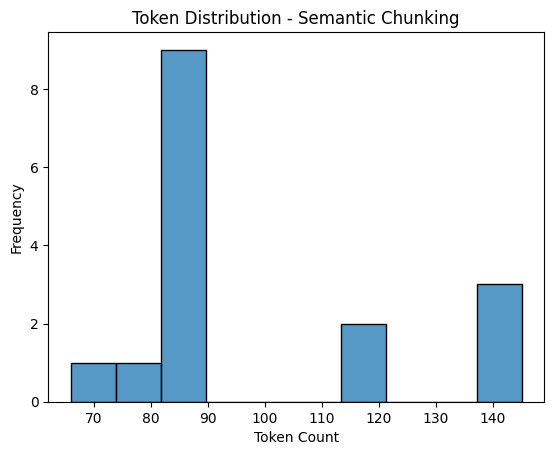

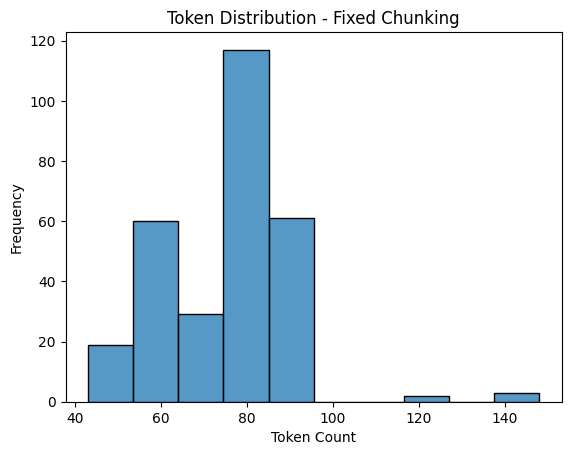

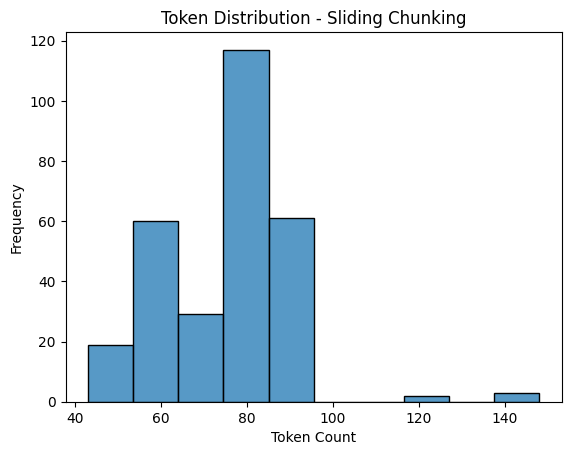

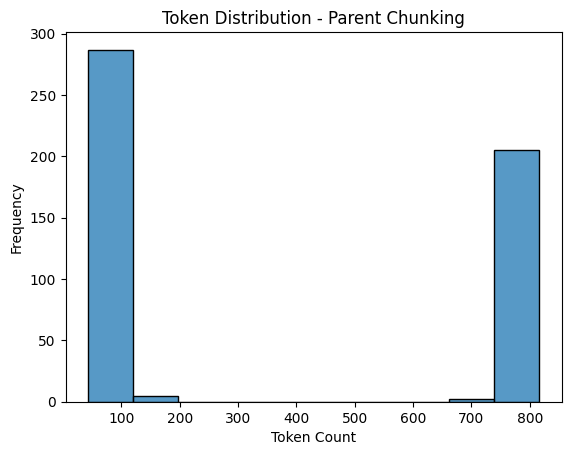

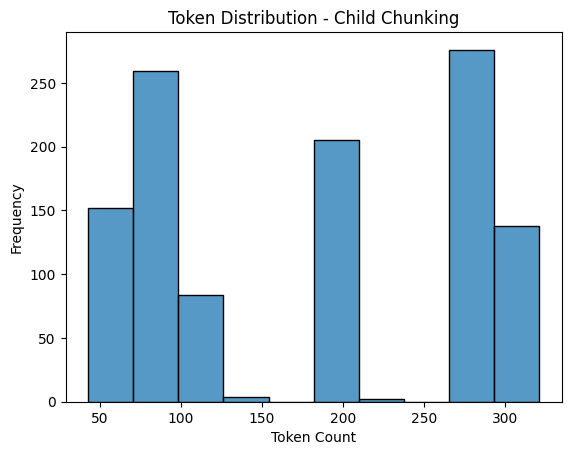

In [19]:
methods = {
    "Semantic": sementic_token_count,
    "Fixed": fixed_token_count,
    "Sliding": sliding_token_count,
    "Parent":parent_token_count,
    "Child":child_token_count
}

for name, tokens in methods.items():
    plt.figure()
    sns.histplot(tokens, bins=10)
    
    plt.xlabel("Token Count")
    plt.ylabel("Frequency")
    plt.title(f"Token Distribution - {name} Chunking")
    
    plt.show()

## **Buid Qdrant vector DB index**

#### **Load Embedding Model**

In [20]:
## load model
from src.context_engineering.services.embedding import _get_embedding_model
embedding_model=_get_embedding_model(env_path=PROJECT_ROOT/".env")

print(f"✅ Embeddings initialized: {EMBEDDING_MODEL}")
print(f"🌐 Provider: {PROVIDER}")

✅ Embeddings initialized: openai/text-embedding-3-large
🌐 Provider: openrouter


#### **Initialize the Qdrant Vector DB**

In [21]:
## import qdrant configuration paramters(URL and API key)
qdrant_configurations=get_api_keys(provider="qdrant",env_path=PROJECT_ROOT/".env")

## initialize the qdrant client
client=QdrantClient(
    url=qdrant_configurations["url"],
    api_key=qdrant_configurations["key"],
    timeout=60
)

## create a qdrant collection 
collection_name = "Pime-Land-Real-Estate-AI-Assistant"

if client.collection_exists(collection_name):
    print(f"Collection '{collection_name}' already exists in Qdrant.")
    print("Deleting the existing collection to create a new one with the same name....")
    client.delete_collection(collection_name=collection_name)

    print(f"Creating a new collection '{collection_name}' with the same name....")
    client.create_collection(
        collection_name=collection_name,
        vectors_config=VectorParams(
            size=3072,
            distance=Distance.COSINE    
        )
    )
else:
    print(f"Collection '{collection_name}' does not exist. Creating a new collection....")
    client.create_collection(
        collection_name=collection_name,
        vectors_config=VectorParams(
            size=3072,
            distance=Distance.COSINE
        )
    )

print(f"✅ Collection '{collection_name}' is ready in Qdrant.")

## generate embeddings using open-ai embedding model

## combine all the chunking strategies
print("="*60)
print("Combining all the chunking strategies.......")
total_chunks=fixed_chunks+sementic_chunks+sliding_window_chunks+parent_child_chunks[0]+parent_child_chunks[1]+late_chunks
print(f"Total length of all the chunks:{len(total_chunks)}")

Collection 'Pime-Land-Real-Estate-AI-Assistant' already exists in Qdrant.
Deleting the existing collection to create a new one with the same name....
Creating a new collection 'Pime-Land-Real-Estate-AI-Assistant' with the same name....
✅ Collection 'Pime-Land-Real-Estate-AI-Assistant' is ready in Qdrant.
Combining all the chunking strategies.......
Total length of all the chunks:2716


In [22]:
## create langchain document and store chunks into qdarnt vector DB as an embeddings
from src.context_engineering.services.embedding_store import(
    build_documents,
    ingest_documents_to_qdrant
)

print("="*60)
print("Creating Langchain Document.........")
lc_documents=build_documents(total_chunks=total_chunks)
print("Document Loaded")
print()
print("="*60)
print("Store embedding inside qdrant")
ingest_documents_to_qdrant(
      documents=lc_documents,
      client=client,
      embedding_model=embedding_model,
      collection_name=collection_name,
      batch_size=BATCH_SIZE
  )


Creating Langchain Document.........
Document Loaded

Store embedding inside qdrant
Starting embedding + ingestion pipeline......
Total documents:2716


100%|██████████| 136/136 [25:35<00:00, 11.29s/it]

Ingestion completed successfully ✅


## **Basic Sanity Checks**

In [23]:
from qdrant_client.models import PayloadSchemaType

print(f"Creating payload index for 'chunking_strategy'...")

# Tell Qdrant to build a fast lookup table for exact string matches (Keyword)
client.create_payload_index(
    collection_name=collection_name,
    field_name="metadata.chunking_strategy",
    field_schema=PayloadSchemaType.KEYWORD,
)

Creating payload index for 'chunking_strategy'...


UpdateResult(operation_id=138, status=<UpdateStatus.COMPLETED: 'completed'>)

In [24]:
query_vector=embedding_model.embed_query("Apartments in Colombo")


## force the qidrant to only retrieve the documents from "Fixed Chunking" strategy
strategy_filter = Filter(
    must=[
        FieldCondition(
            key="metadata.chunking_strategy",
            match=MatchValue(value="Fixed Strategy"),
        )
    ]
)
results=client.query_points(
    collection_name=collection_name,
    query=query_vector,
    query_filter=strategy_filter,
    limit=10
)


score=[]
for i, r in enumerate(results.points):
    print(f"Rank {i+1}")
    print(f"Score: {r.score:.4f}")
    print(f"Title: {r.payload.get('title')}")
    print(f"Url: {r.payload.get('url')}")
    print(f"Text: {r.payload.get('text')[:200]}...")
    print("="*60)

    ##collect score
    score.append(r.score)




Rank 1
Score: 0.6047
Title: None
Url: None
Text: Title:Apartments
Property Id:COMPLETE
Price:86,000,000 LKR
Bedrooms:2-3
Bathrooms:2-3
---
Home

Lands

Houses

Apartments

Portfolio Properties

Contact Us

සිං   |   

தமி...
Rank 2
Score: 0.5525
Title: None
Url: None
Text: Title:NELUMDENIYA - LOTUS AVENUE
Property Id:NELUMDENIYA LOTUS AVENUE
Price:70,000 LKR
---
Home

Lands

Houses

Apartments

Portfolio Properties

Contact Us

සිං   |   

தமி...
Rank 3
Score: 0.5461
Title: None
Url: None
Text: Title:NELUMDENIYA - LOTUS AVENUE
Property Id:NELUMDENIYA LOTUS AVENUE
Price:70,000 LKR
---
முகப்பு பக்கம்

நிலங்கள்

வீடுகள்

அபார்ட்மெண்ட்ஸ்

பமுதலீட்டு சொத்து

தொடர்புகளுக்கு

En   |   

සිං...
Rank 4
Score: 0.5417
Title: None
Url: None
Text: Title:PRIME ELYSIUM KOTTAWA
Property Id:PRIME ELYSIUM KOTTAWA
Price:1,600,000 LKR
---
Home

Lands

Houses

Apartments

Portfolio Properties

Contact Us

සිං   |   

தமி...
Rank 5
Score: 0.5410
Title: None
Url: None
Text: Title:PARADISE AVENUE NEGOMBO
Pro

## **Perfomance Checking**

In [25]:
## check performance for all chunking strategy
## Metrics checks:
##   - Average Token Count
##   - Chunk Count
##   - Retrievel Time
##   - Index Size

## import custom function to generate performance comparison table
from src.context_engineering.services.performance_check import generate_comparison_table

print("="*60)
print("Generating performance comparison table for all chunking strategies........")
comparison_table=generate_comparison_table(
     qdrant_client=client,
     collection_name=collection_name,
     embedding_model=embedding_model,
     total_chunks=total_chunks
 )
print("Performance comparison table generated successfully")
print("="*60)
print(comparison_table)



Generating performance comparison table for all chunking strategies........
🔍 Gathering metrics for all strategies... Please wait.

Performance comparison table generated successfully
            Strategy  Chunk Count  Avg Size(Tokens)  \
3     Child Strategy         1120            180.82   
2   Sliding Strategy          291             75.33   
4      Late Strategy          499            367.50   
1  Sementic Strategy           16             97.81   
0     Fixed Strategy          291             75.33   

   Estimated(Index )Size(MB)  Retrieval Time(ms)  
3                      13.12              672.07  
2                       3.41              684.33  
4                       5.85              716.11  
1                       0.19              743.23  
0                       3.41              879.84  
